## Настройка базовых параметров

In [106]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras.models
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import shutil
import pickle

#инициализируем пути
train_path = "dataset/train"
test_path = "dataset/test"
result_paths = ["dataset/saved_cnn", "dataset/saved_ffnn"]
plot_paths = ["loss-accuracy-сnn.png", "loss-accuracy-ffnn.png"]
model_names = ["model_CNN.h5", "model_FFNN.h5"]
history_names = ["train-history-dict-CNN", "train-history-dict-FFNN"]

EPOCHS = 17
seed = 75 

#очистка старых результатов
for result_path in result_paths:
    if os.path.exists(result_path):
        shutil.rmtree(result_path)
    os.makedirs(result_path)

# инициализируем данные и метки
data = []
labels = []
train_labels = os.listdir(train_path)
train_labels.sort()
      

## Функции

In [118]:
def make_data(i, train_labels, train_path):
    """Функция загружает преобразованные изображения в data,
    а также сохраняет соответсвующие метки и данные в picle файлы"""
    
    data = list()
    labels = list()
    
    # цикл по изображениям из папки train - вытаскиваем картинки и кладем в data, их класс (имя симпсона) в labels
    for training_name in train_labels:
        dir = os.path.join(train_path, training_name)
        current_label = training_name

        path = train_path + "/" + training_name
        x = os.listdir(dir)

        for y in x:
            file = path + "/" + str(y)

            image = cv2.imread(file)
            if not i:
                
                image = cv2.resize(image, (32, 32))
            else :
                image = cv2.resize(image, (32, 32)).flatten()
            data.append(image)

            labels.append(current_label)

        print("[INFO] processed folder: {}".format(current_label))
    # масштабируем интенсивности пикселей в диапазон [0, 1], нейросеть с ними работает эффективнее
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    
    pickle.dump(data, open(f"data{i}.pkl", "wb"))
    pickle.dump(labels, open(f"labels{i}.pkl", "wb"))
    
    return data, labels

def make_model(i, trainX, testX, trainY, testY):
    if not i:
        return makeCNN_model(trainX, testX, trainY, testY)
    else:
        return makeFFNN_model(trainX, testX, trainY, testY) 

def makeFFNN_model(trainX, testX, trainY, testY):
    """функция настраивает и создает модель, а также тренирует ее на train data. Для оптимизации настроенная модель сохраняется в файле *.h5"""
    
    
#     lb = LabelBinarizer()
#     trainY = lb.fit_transform(trainY)
#     testY = lb.transform(testY)
    # определим архитектуру 2743-1024-512-3 с помощью Keras
    model = Sequential()
    model.add(Dense(1024, input_shape=(3072,), activation="sigmoid"))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dense(len(lb.classes_), activation="softmax"))


    # компилируем модель, используя Adam как оптимизатор и категориальную кросс-энтропию в качестве функции потерь
    print("[INFO] training network...")
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    # архитектура нейронки
    model.summary()

    # обучаем нейросеть
    H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)
    
    model.save(model_names[1])
    
    with open(history_names[1], 'wb') as file_pi:
        pickle.dump(H.history, file_pi)
    
    return model, H.history



def makeCNN_model(trainX, testX, trainY, testY):
    """функция настраивает и создает модель, а также тренирует ее на train data. Для оптимизации настроенная модель сохраняется в файле *.h5"""
    
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="sigmoid"))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation="sigmoid"))
    model.add(Dropout(0.25))
    model.add(Dense(len(lb.classes_), activation="softmax"))
    

    # компилируем модель, используя Adam как оптимизатор и категориальную кросс-энтропию в качестве функции потерь
    print("[INFO] training network...")
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    # архитектура нейронки
    model.summary()

    # обучаем нейросеть, H - история тренировки модели
    H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)
    model.save(model_names[0])
    with open(history_names[0], 'wb') as file_pi:
        pickle.dump(H.history, file_pi)
    return model, H.history

def testing(i_, test_labels, result_path):
    """Тестируем модель на файлах из test"""
    
    # цикл по изображениям test
    for test_file in test_labels:
        # загружаем входное изображение и меняем его размер на необходимый
        path_for_save = result_path + "/" + test_file
        test_file = test_path + "/" + test_file
        image = cv2.imread(test_file)
        image_copy = image.copy()
        
        if not i_:
            image = cv2.resize(image, (32, 32))
            # масштабируем значения пикселей к диапазону [0, 1]
            image = image.astype("float") / 255.0
            image = image.reshape((1, *image.shape))
        else :
            image = cv2.resize(image, (32, 32)).flatten()
            # масштабируем значения пикселей к диапазону [0, 1]
            image = image.astype("float") / 255.0
            image = image.reshape((1, image.shape[0]))

        # массив предсказания класса картинки
        predictions = model.predict(image)
        # находим индекс класса с наибольшей вероятностью
        i = predictions.argmax(axis=1)[0]
        label = lb.classes_[i]

        # выводим название класса и вероятность принадлежности на картинку
        text = f'{label}: {round(predictions[0][i] * 100, 2)}%'
        cv2.putText(image_copy, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 2)
        plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
        plt.show()
        cv2.imwrite(path_for_save, image_copy)
        
        
def make_plot(i, H):
    """Cтроим графики потерь и точности"""
    plt.style.use("ggplot")
    N = np.arange(0, EPOCHS)
    plt.figure()
    plt.plot(N, H["loss"], label="training loss")
    plt.plot(N, H["val_loss"], label="validation loss")
    plt.plot(N, H["accuracy"], label="training accuracy")
    plt.plot(N, H["val_accuracy"], label="validation accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig(plot_paths[i])
    plt.show()



## Main



**********************************************************************************


[INFO] training network...
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 128)               262272    
_____

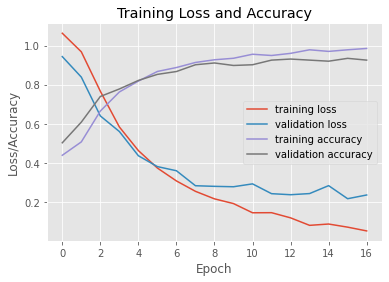

[INFO] loading images for testing...
test labels = ['13a48fe3c8f11d7eb0f18a637e52d637.jpeg', 'Lenny_simpsonsworld.png', 'Milhouse_Van_Houten.png', 'Tapped_Out_Unlock_Milhouse.png', 'b088e5db6b560a33fc20e666a46263b3.jpeg', 'maxresdefault.jpeg', 'simpsons_PNG25.png', 'the-simpsons-lisa-1589201259.jpeg', 'unnamed.jpeg']


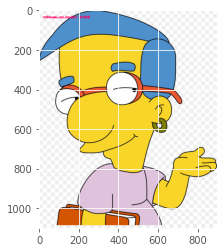

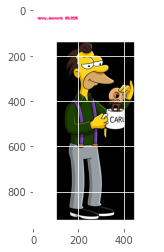

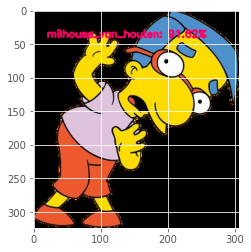

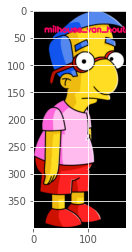

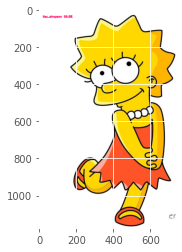

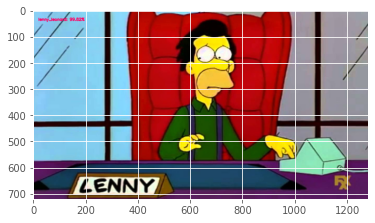

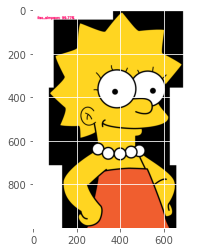

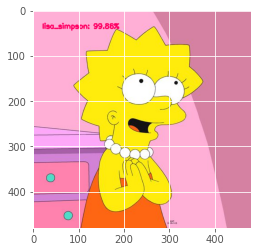

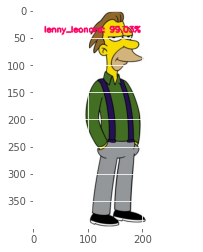



**********************************************************************************


[INFO] training network...
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 1024)              3146752   
_________________________________________________________________
dense_127 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_128 (Dense)            (None, 3)                 1539      
Total params: 3,673,091
Trainable params: 3,673,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/17
69/69 [==============================] - 1s 16ms/step - loss: 1.1589 - accuracy: 0.5198 - val_loss: 0.7531 - val_accuracy: 0.7013
Epoch 2/17
69/69 [==============================] - 1s 14ms/step - loss: 0.6748 - accuracy: 0.7146 - val_loss: 0.6333 

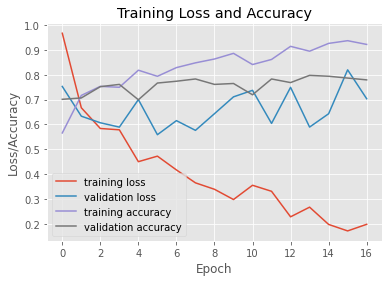

[INFO] loading images for testing...
test labels = ['13a48fe3c8f11d7eb0f18a637e52d637.jpeg', 'Lenny_simpsonsworld.png', 'Milhouse_Van_Houten.png', 'Tapped_Out_Unlock_Milhouse.png', 'b088e5db6b560a33fc20e666a46263b3.jpeg', 'maxresdefault.jpeg', 'simpsons_PNG25.png', 'the-simpsons-lisa-1589201259.jpeg', 'unnamed.jpeg']


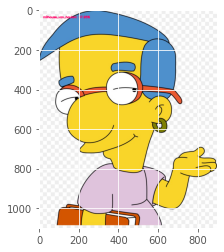

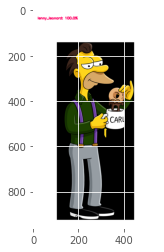

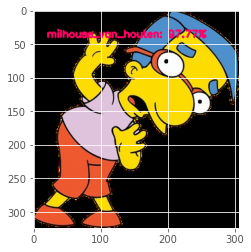

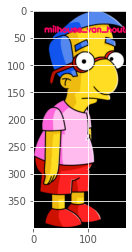

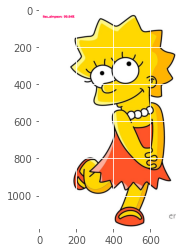

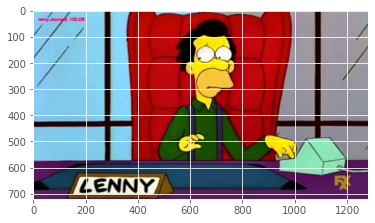

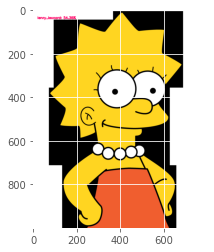

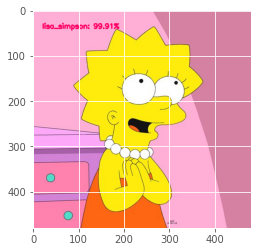

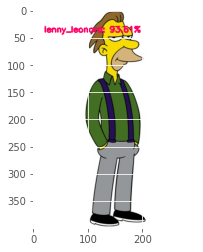

In [119]:


for i in range (0, 2):
    if os.path.exists(f"data{i}.pkl" and f"labels{i}.pkl"):
        data = pickle.load(open(f"data{i}.pkl", 'rb'))
        labels  = pickle.load(open(f"labels{i}.pkl", 'rb'))
    else:
        data, labels = make_data(i, train_labels, train_path)
    
    # разбиваем данные на обучающую и тестовую выборки, используя 80% данных для обучения и оставшиеся 20% для тестирования
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=seed)
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.transform(testY)
    print("\n\n**********************************************************************************\n\n")
    
    

    # разбиваем данные на обучающую и тестовую выборки, используя 80% данных для обучения и оставшиеся 20% для тестирования
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=seed)
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.transform(testY)

    retrain = True
    if os.path.exists(model_names[i]) and not(retrain):
        model = keras.models.load_model(model_names[i])
        H = pickle.load(open(history_names[i], 'rb'))
    else:
        model, H = make_model(i, trainX, testX, trainY, testY)



    # оцениваем нейросеть
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

    #Cтроим графики потерь и точности
    make_plot(i,H)

    # начинаем предсказывать принадлежность к классу
    print("[INFO] loading images for testing...")
    test_labels = os.listdir(test_path)
    test_labels.sort()
    print("test labels =", test_labels)


    testing(i, test_labels, result_paths[i])
    